In [451]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [506]:
#Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from copy import deepcopy
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from warnings import filterwarnings
filterwarnings(action = 'ignore')
%matplotlib inline

In [799]:
raw = pd.read_csv('hospital_diabetes_dataset.csv')
df = deepcopy(raw)

In [698]:
df.tail()

,Pregnancies,AmountofGlucose,Pressureofblood,Thicknessofskin,amountofInsulin,BMI,DiabetesPedigree,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


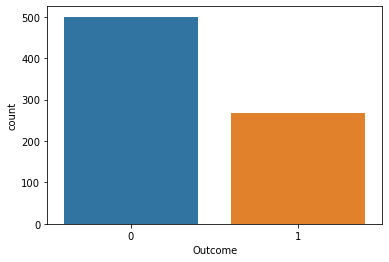

In [56]:
sns.countplot(df.Outcome)
plt.show();

In [733]:
#34 to 66 percent. We won't be oversampling
df.loc[~(df.Outcome==0)].shape[0]/df.shape[0]

0.3489583333333333

In [734]:
#No missing values
df[df.isna().any(axis=1)].shape[0]

0

#### Data Preprocessing: Feature Selection

In [457]:
df.corr(method='spearman')['Outcome'].iloc[:-1].reset_index().T

,0,1,2,3,4,5,6,7
index,Pregnancies,AmountofGlucose,Pressureofblood,Thicknessofskin,amountofInsulin,BMI,DiabetesPedigree,Age
Outcome,0.198689,0.475776,0.142921,0.089728,0.066472,0.309707,0.175353,0.30904


In [458]:
for col in df.columns[:-1]:
    print(f'''{col} variance: {df[col].var()}''')

Pregnancies variance: 11.35405632062142
AmountofGlucose variance: 1022.2483142519557
Pressureofblood variance: 374.6472712271838
Thicknessofskin variance: 254.47324532811953
amountofInsulin variance: 13281.180077955281
BMI variance: 62.15998395738257
DiabetesPedigree variance: 0.10977863787313938
Age variance: 138.30304589037365


In [459]:
for col in df.columns:
    print(f'''{col}: {df[col].nunique()}''') 

Pregnancies: 17
AmountofGlucose: 136
Pressureofblood: 47
Thicknessofskin: 51
amountofInsulin: 186
BMI: 248
DiabetesPedigree: 517
Age: 52
Outcome: 2


In [113]:
def plot_hist(data):
    for col in data.columns[:-1]:
        sns.displot(data[col], bins=20)
        plt.show();

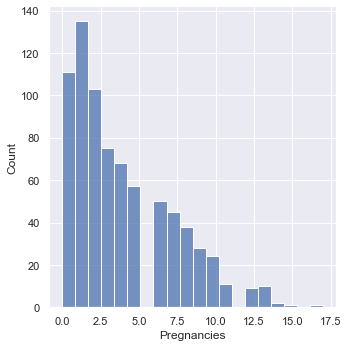

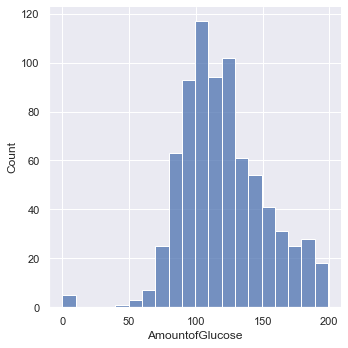

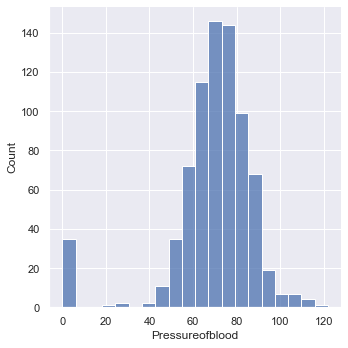

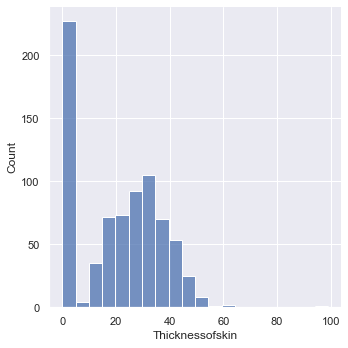

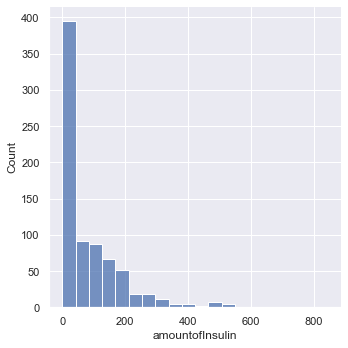

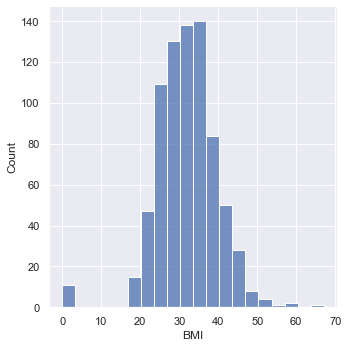

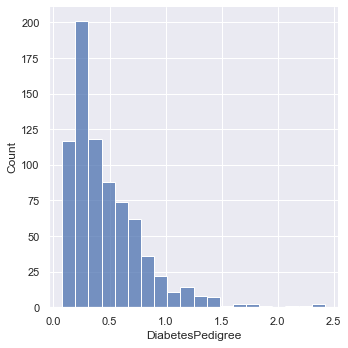

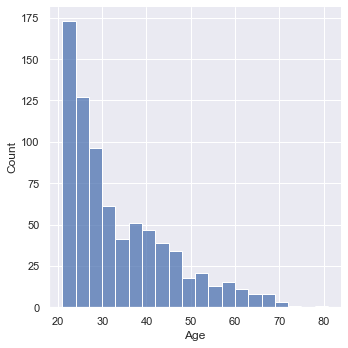

In [114]:
plot_hist(df)

In [460]:
def check_skewness(data):
    for col in data.columns[:-1]:
        print(f'''{col} skewness: {data[col].skew()}''')

In [461]:
check_skewness(df)

Pregnancies skewness: 0.9016739791518588
AmountofGlucose skewness: 0.17375350179188992
Pressureofblood skewness: -1.8436079833551302
Thicknessofskin skewness: 0.10937249648187608
amountofInsulin skewness: 2.272250858431574
BMI skewness: -0.42898158845356543
DiabetesPedigree skewness: 1.919911066307204
Age skewness: 1.1295967011444805


#### What's interesting is, there're numerous records of people with 0 insulin levels. I don't know during what time of the day their levels were recorded. Additionally, in general, we've got columns with a lot of zero values. Let's dive deeper into this phenomenon.

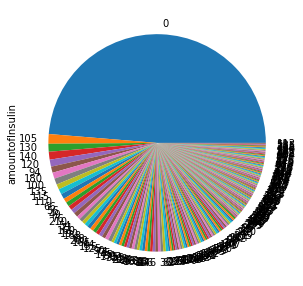

In [84]:
#It seems around 50 percent
plt.figure(figsize=(5,5))
df['amountofInsulin'].value_counts().plot(kind='pie')
plt.show();

In [462]:
#Yes, roughly
df.loc[df.amountofInsulin==0].shape[0]/df.shape[0]

0.4869791666666667

In [463]:
def check_zero_pct(data):
    for col in data.columns[:-1]:
        zero_pct = data.loc[data[col]==0].shape[0]/data.shape[0]
        print(f'''For {col}: {zero_pct}''')

In [464]:
#Turns out this zero phenomenon is mostly the case for thicknessofskin and amounofinsulin feaures (30 and 50 pct)
check_zero_pct(df)

For Pregnancies: 0.14453125
For AmountofGlucose: 0.006510416666666667
For Pressureofblood: 0.045572916666666664
For Thicknessofskin: 0.2955729166666667
For amountofInsulin: 0.4869791666666667
For BMI: 0.014322916666666666
For DiabetesPedigree: 0.0
For Age: 0.0


##### It's interesting that when the zero values of Insulin is not taken into account, the correlation between the features and the outcome actually increases.

In [465]:
df.loc[df.amountofInsulin!=0].corr() 

,Pregnancies,AmountofGlucose,Pressureofblood,Thicknessofskin,amountofInsulin,BMI,DiabetesPedigree,Age,Outcome
Pregnancies,1.000000,0.201487,0.213740,0.095997,0.082171,-0.011282,-0.000402,0.680920,0.258846
AmountofGlucose,0.201487,1.000000,0.203356,0.203526,0.580010,0.208711,0.140409,0.346041,0.512201
Pressureofblood,0.213740,0.203356,1.000000,0.232342,0.098272,0.301530,-0.020834,0.299845,0.192819
Thicknessofskin,0.095997,0.203526,0.232342,1.000000,0.184888,0.653425,0.154056,0.170694,0.257854
amountofInsulin,0.082171,0.580010,0.098272,0.184888,1.000000,0.228328,0.130395,0.220261,0.303454
BMI,-0.011282,0.208711,0.301530,0.653425,0.228328,1.000000,0.112954,0.080778,0.271796
DiabetesPedigree,-0.000402,0.140409,-0.020834,0.154056,0.130395,0.112954,1.000000,0.076609,0.200759
Age,0.680920,0.346041,0.299845,0.170694,0.220261,0.080778,0.076609,1.000000,0.352982
Outcome,0.258846,0.512201,0.192819,0.257854,0.303454,0.271796,0.200759,0.352982,1.000000


In [108]:
def plot_heatmap(data):
    sns.set(rc={'figure.figsize':(10,7)})
    mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    sns.heatmap(data.corr(), mask=mask, annot=True)
    plt.show() 

##### The features, for the most part, are not significantly related to one another, with the exception of amountofInsulin and AmountofGlucose. But they're also not highly correlated.

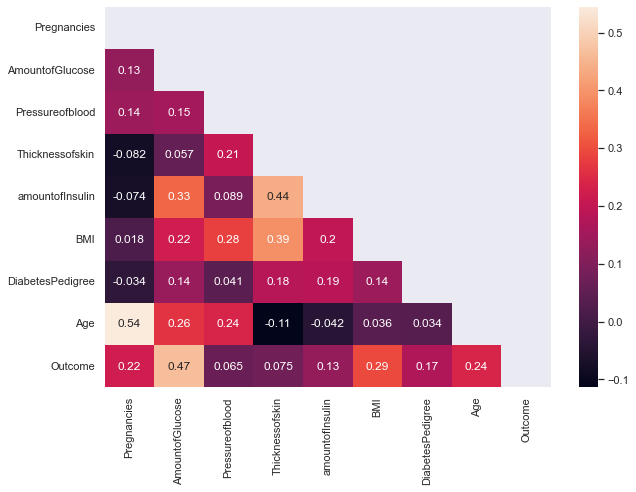

In [109]:
plot_heatmap(df)

##### We've now dropped some of our features with the help of Filtering method. Now, let's check the VIF. It generally doesn't affect the performance of a model, but it does affect the significance of a certain feature.

In [800]:
class handle_vif():
    
    def __init__(self, data):
        self.data = data
        
    def compute_vif(self, considered_features: list):
        self.considered_features = considered_features
        X = self.data[self.considered_features]
        X['intercept'] = 1
        
        self.vif = pd.DataFrame()
        self.vif["Variable"] = X.columns
        self.vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        self.vif = self.vif[self.vif['Variable']!='intercept']
        return self.vif
    
    def drop_high_vif(self):
        self.vif_table = self.vif.sort_values(by='VIF', ascending=False).reset_index(drop=True) 
    
        while self.vif_table['VIF'].iloc[0]>5:
            self.data.drop(self.vif_table['Variable'][0], axis=1, inplace=True)
            computed = self.compute_vif([col for col in df.columns if col!='BodyFat']) 
            self.vif_table = computed.sort_values(by='VIF', ascending=False).reset_index(drop=True) 

        return self.data.head()  

In [801]:
vif = handle_vif(df)

In [802]:
#All of them are less than 5 which we've set as a threshold
vif.compute_vif([col for col in df.columns[:-1]])

,Variable,VIF
0,Pregnancies,1.430872
1,AmountofGlucose,1.298961
2,Pressureofblood,1.181863
3,Thicknessofskin,1.507432
4,amountofInsulin,1.427536
5,BMI,1.297450
6,DiabetesPedigree,1.067090
7,Age,1.588368


In [803]:
df.duplicated().sum()

0

In [804]:
def find_outliers_iqr(data, outlier_range_val=1.7):
    for column in data.select_dtypes(include='number'):
        Q3 = data[column].quantile(q = 0.75)
        Q1 = data[column].quantile(q = 0.25)
        IQR = Q3 - Q1
        outlier_range = IQR * outlier_range_val
        upperlimit = Q3 + outlier_range
        lowerlimit = Q1 - outlier_range
        no_outliers = data.loc[(data[column]>upperlimit) | (data[column]<lowerlimit)].shape[0]
        print(f'''Number of outlier records in {column} column: {no_outliers}''')   

In [805]:
find_outliers_iqr(df)

Number of outlier records in Pregnancies column: 2
Number of outlier records in AmountofGlucose column: 5
Number of outlier records in Pressureofblood column: 40
Number of outlier records in Thicknessofskin column: 1
Number of outlier records in amountofInsulin column: 25
Number of outlier records in BMI column: 17
Number of outlier records in DiabetesPedigree column: 22
Number of outlier records in Age column: 3
Number of outlier records in Outcome column: 0


In [806]:
def impute_outliers(value):
    if value > upperlimit:
        value = upperlimit
    elif value < lowerlimit:
        value = lowerlimit
    return value

for feature in df.columns[:-1]:
    Q3 = df[feature].quantile(q = 0.75)
    Q1 = df[feature].quantile(q = 0.25)
    IQR = Q3 - Q1 
    outlier_range = IQR * 1.5
    upperlimit = Q3 + outlier_range
    lowerlimit = Q1 - outlier_range
    df[feature] = df[feature].apply(impute_outliers)

In [807]:
#Premodeling
x = df.iloc[:,:-1] 
y = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=200)

scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train)

scaler = RobustScaler()
x_test = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test) 

In [808]:
def get_model_metrics(x_train, y_train, x_test, y_test, preds, mdl):
    
    train_acc = mdl.score(x_train,y_train)
    test_acc = mdl.score(x_test, y_test)
    rmse = (np.sqrt(mean_squared_error(y_test, preds)))
    
    results = {'Train_acc': train_acc, 'Test_acc': test_acc, 'rmse': rmse}
    model = 'Value'
    model_metrics = pd.DataFrame(results.items(), columns = ['Metric', str(model)]).set_index('Metric')
    return model_metrics

In [811]:
def classification_metrics(x_train, y_train, x_test, y_test, preds ,probs ,mdl): #Evaluation Metrics
    Accuracy = accuracy_score(y_test, preds)
    Precision  = precision_score(y_test, preds)
    Recall = recall_score(y_test, preds)

    #Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, preds, labels=[0,1]))
    TN = cm[0][0]                                                                                       
    FN = cm[0][1]                                                                                          
    FP = cm[1][0]                                                                                       
    TP = cm[1][1]
    TPR = TN/(FP+TN)   
    FPR = FP/(FP+TN)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr )

    logit_summary = {'Accuracy': Accuracy, 
                     'Precision': Precision, 
                     'Recall': Recall, 
                     'True Positive Rate': TPR, 
                     'False Positive Rate': FPR,
                    }
    
    model = 'Value'
    class_metrics = pd.DataFrame(logit_summary.items(), columns = ['Metric', str(model)]).set_index('Metric')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(mdl, x_test, y_test, cmap=plt.cm.Blues, ax=ax)
    plt.tight_layout()
    plt.title('Confusion Matrix', y = 1.1)
    
    return class_metrics

### Logistic Regression

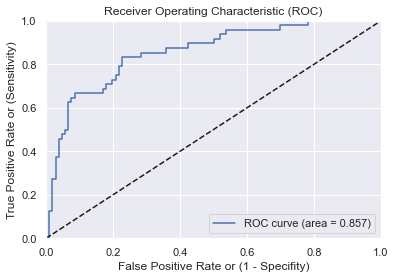

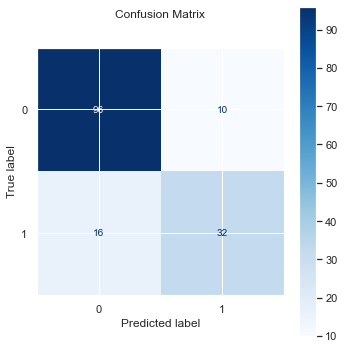

,Metric,Value,Model
0,Train_acc,0.767101,Logisitc
1,Test_acc,0.831169,Logisitc
2,rmse,0.410891,Logisitc
3,Accuracy,0.831169,Logisitc
4,Precision,0.761905,Logisitc
5,Recall,0.666667,Logisitc
6,True Positive Rate,0.905660,Logisitc
7,False Positive Rate,0.094340,Logisitc


In [812]:
logit = LogisticRegression(solver='liblinear')
logit.fit(x_train, y_train)
logit_preds = logit.predict(x_test)
logit_probs = logit.predict_proba(x_test)[:,1]
logit_probs2 = logit.predict_proba(x_test)

model_metrics = get_model_metrics(x_train, y_train, x_test, y_test, logit_preds, logit)

class_metrics = classification_metrics(x_train, y_train, x_test, y_test, logit_preds,logit_probs, logit)
y_true = y_test.values

metrics_list = [model_metrics, class_metrics]
lgrmetrics = pd.concat(metrics_list)
lgrmetrics = lgrmetrics.reset_index()
lgrmetrics['Model'] = 'Logisitc'

plt.show();
lgrmetrics

### RandomForest

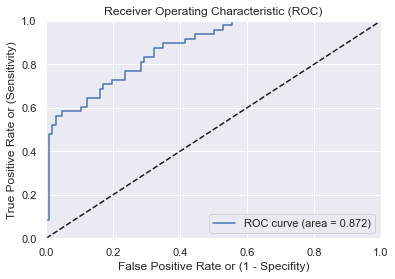

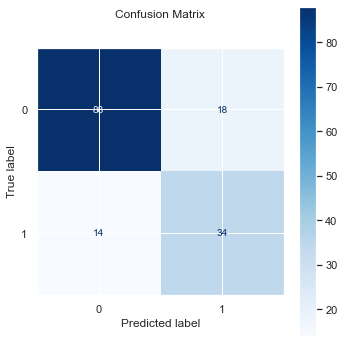

,Metric,Value,Model
0,Train_acc,1.000000,Forest
1,Test_acc,0.792208,Forest
2,rmse,0.455842,Forest
3,Accuracy,0.792208,Forest
4,Precision,0.653846,Forest
5,Recall,0.708333,Forest
6,True Positive Rate,0.830189,Forest
7,False Positive Rate,0.169811,Forest


In [813]:
#Random Forest gave us the better results
rfc = RandomForestClassifier(n_estimators=500, max_depth=12)
rfc = rfc.fit(x_train, y_train)
forest_preds = rfc.predict(x_test)
forest_probs = rfc.predict_proba(x_test)[:,1]

model_metrics = get_model_metrics(x_train, y_train, x_test, y_test, forest_preds, rfc)

class_metrics = classification_metrics(x_train, y_train, x_test, y_test, forest_preds, forest_probs, rfc)

metrics_list = [model_metrics, class_metrics]
forest_metrics = pd.concat(metrics_list)
forest_metrics['Model'] = 'Forest'
plt.show();
forest_metrics = forest_metrics.reset_index()
forest_metrics

##### Some features were moderately correlated, so I chose not to implement forward/backward elimination